In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Vortex panel solution method

This section will use vortex panels to solve to the flow around general objects by setting up and solving a system of linear equations.

## General vortex sheets

A curved vortex sheet with a variable strength can describe the flow around any immersed object. This is achieved by having the sheet act as an infinitely thin version of the boundary layer to enforce the no-slip boundary condition. 

---

<img src="resources/impulse.png" width="700">

---

In other words we use the sheets to force the tangential velocity $u_s$ to zero at every point $s$ on the body surface $\cal S$

\begin{equation}
u_s = \vec u \cdot \hat s = 0 \quad s \in \cal S
\end{equation}

From the previous notebook, we know the velocity at any point is determined by an integral over the whole vortex sheet. Therefore, the tangential velocity condition is

\begin{equation}
\left[\vec U+\frac{\partial}{\partial \vec x}\oint_{\cal S} \frac{\gamma(s')}{2\pi}\theta(s,s')\ ds'\right] \cdot\hat s = 0 
\end{equation}

where $\vec U_\infty$ is the background velocity that has been added by superposition. 

**If we can use this equation to determine the strength distribution $\gamma(s)$ along the sheet then we will have solved for the potential flow around the body!**

## Discrete vortex panels

For general body surface shapes the velocity is a highly nonlinear function of $\gamma(s)$, rendering analytic solution unlikely. We could attempt some complex analytic expansions, but why would we want to do that?

##### Numerical fundamental: Discritization
##### Replace continuous functions with linear approximations

We already know that the velocity depends **linearly** on $\gamma$ for a vortex panel. This makes it easy to solve for $\gamma$ as a function of $u_s$.

If we break up the continuous sheet into a series of vortex panels, we can add their influence together using superposition. We can then apply the no slip boundary condition, and use it to solve for $\gamma$. 

<img src="resources/graphics2.png" width="700">


This is the essence of the *vortex panel method*.

---

## Array of panels

To help make this more concrete, lets consider a polygon-shape body. I found this beautiful little equation to define the radius of [regular polygons](http://math.stackexchange.com/questions/41940/is-there-an-equation-to-describe-regular-polygons/41954#41954) in polar coordinates.
$$ r=\frac{\cos\left(\frac{\pi}{n}\right)}{\cos\left(\left(\theta \mod \frac{2\pi}{n}\right) -\frac{\pi}{n}\right)} $$

where $\theta$ is the polar angle around the origin and $n$ is the number of sides in the polygon. Using this equation, we can write a function to produce a set of $x,y$ points along a polygon:
```python
def make_polygon(N,sides):
    theta = numpy.linspace(0, -2*numpy.pi, N+1)          # equally spaced theta
    r = numpy.cos(numpy.pi/sides)/numpy.cos(             # r(theta)
            theta % (2.*numpy.pi/sides)-numpy.pi/sides)
    x, y = r*numpy.cos(theta), r*numpy.sin(theta)        # points defining the shape
    return panelize(x, y)                                # make panels
```
where `N` is the number of panels to make. The last line joins up the points into a list of `Panel`s (like in the figure) and stores them in a `PanelArray` object:
```python
def panelize(x,y):
    panels = [Panel(x[i], y[i], x[i+1], y[i+1]) for i in range(len(x)-1)]
    return PanelArray(panels)
```

The `make_polygon` function has already been implemented in the `VortexPanel` module. Since we're going to use many functions in that module lets import the whole thing (like we do for `numpy`), and since it has a long name, lets give it the nick-name `vp`:

In [26]:
import numpy
from matplotlib import pyplot
%matplotlib notebook
import VortexPanel as vp

You can see that the `help` function tells you everything you need to know about the function. So lets use the two lines in the help example to make a triangle of panels and plot it:

<IPython.core.display.Javascript object>


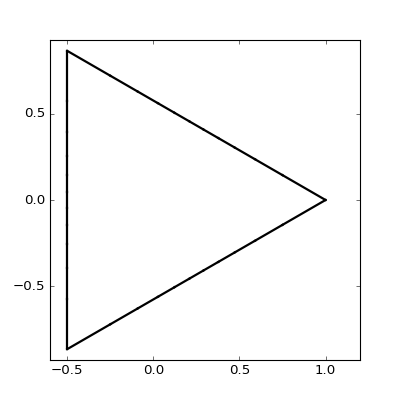

In [13]:
triangle = vp.make_polygon(N=33,sides=3)  # make a triangular Panel array
pyplot.figure(figsize=(5,5))
pyplot.axis('equal')
triangle.plot() #style='o-')              # plot the geometry

Play around with the `style` argument to see the points and panels that make up the shape. 

Note that in addition to holding `triangle.panels`, the `PanelArray` object also has some really useful functions like `triangle.plot()`.

---
Now that we have an example, what is the velocity induced by these panels and the uniform flow? 

Using superposition, the total velocity at any point $x,y$ is simply

\begin{equation}
\vec u(x,y) = \vec U+\sum_{j=0}^{N-1} \vec u_j(x,y)
\end{equation}

where we use the index  $j$ to label each of the $N$ panels. This is easily implemented for an array of panels:

```python
# get the uniform velocity with AOA `alpha`
u, v = numpy.cos(alpha), numpy.sin(alpha)
    
# add the velocity contribution from each panel
for p_j in panels:
    u_j, v_j = p_j.velocity(x, y)
    u, v = u+u_j, v+v_j
```
where the `for-in` notation loops through every panel in the array.

---
The function `PanelArray.plot_flow(size=2)` uses this superposition code to visualize the flow. As always, you can use `help(vp.PanelArray.plot_flow)` (or `help(triangle.plot_flow)`) to see the detailed documentation.

Let's plot the triangle flow:

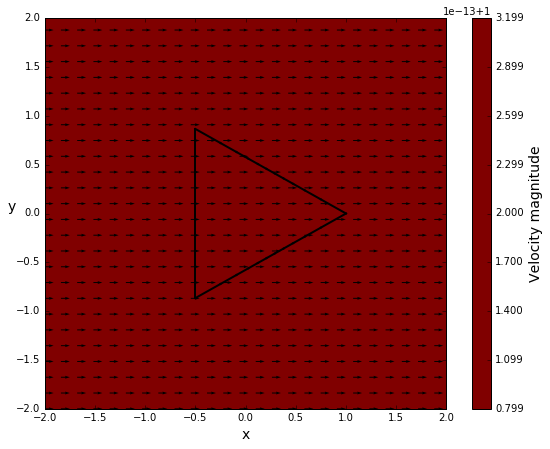

In [4]:
triangle.plot_flow()

##### Quiz

Why is the flow going through the body above?

1. We set `gamma=0` for the panels
1. We haven't applied the no-slip condition
1. We haven't determined the correct `gamma` for each panel

## System of linear equations

One key to the solution method is that the velocity $\vec u_j$ induced by vortex panel $j$ depends __linearly__ on $\gamma_j$. So lets write $\vec u_j$ in a way that makes the linearity explicit:

$$ \vec u_j(x,y)=\gamma_j\ \vec f_j(x,y)$$

where $\vec f_j$ is the velocity function we defined in the last notebook which depends only on geometry.

Substituting this linear relation for the velocity $\vec u_j$ into the total velocity equation (3) and applying the no-slip boundary condition (1) we have:

$$ u_s = \left[\vec U + \sum_{j=0}^{N-1} \gamma_j \ \vec f_j(x,y)\right]\cdot\hat s=0 $$

So the goal is to set $\gamma$ on each panel such that this condition is enforced on the body.

##### Quiz

How many unknowns are there?

1. $1$
1. $N$
1. $N^2$

But we only have one equation, the no-slip condition... right?

##### Numerical fundamental: Consistency
##### Develop enough equations to match the unknowns

We need to have as many equations as we have unknowns to be consistent and to be able to determine a solution.

Luckily the no-slip condition is a continuous equation - it applies to *every* point on the body. Therefore, we can evaluate the boundary equation **on each panel**. Then we will have a consistent linear system.

---

Let's start with one panel, say panel $i$, and set the total tangential velocity at the center of the panel to zero:

$$ \frac 12 \gamma_i + \vec U\cdot\hat s_i + \sum_{j=0, j\ne i}^{N-1} \gamma_j \ \vec f_j(x_i,y_i)\cdot\hat s_i= 0 $$

Note that we've used the simple relation from the previous notebook

$$ \vec u_i(x_i,y_i) \cdot \hat s_i = \frac 12 \gamma_i $$

for the tangential velocity that the panel induces on itself.

Next, let's write the summation as an inner product of two arrays in order to separate out the knowns from the unknowns:

$$
\begin{bmatrix} \vec f_0(x_i,y_i)\cdot\hat s_i & \vec f_1(x_i,y_i)\cdot\hat s_i & \cdots & \frac 12 & \cdots & \vec f_{N-1}(x_i,y_i)\cdot\hat s_i\end{bmatrix} \times \begin{bmatrix} \gamma_0 \\ \gamma_1 \\ \vdots \\ \gamma_i \\ \vdots \\ \gamma_{N-1} \end{bmatrix} + \vec U \cdot \hat s_i = 0
$$

Written like this, we can see two things:

 - The no-slip condition on panel $i$ depends on the strength at every panel, and
 - This is just the $i$th row of a matrix of equations

\begin{equation}
\begin{bmatrix} 
\frac 12  & \vec f_1(x_0,y_0)\cdot\hat s_0 & \cdots & \vec f_{N-1}(x_0,y_0)\cdot\hat s_0\\[0.5em]
\vec f_0(x_1,y_1)\cdot\hat s_1 & \frac 12 & \cdots & \vec f_{N-1}(x_1,y_1)\cdot\hat s_1 \\[0.5em]
\vdots & \vdots & \ddots & \vdots \\[0.5em] 
\vec f_0(x_{N-1},y_{N-1})\cdot\hat s_{N-1} & \vec f_1(x_{N-1},y_{N-1})\cdot\hat s_{N-1} & \cdots & \frac 12
\end{bmatrix} 
\times \begin{bmatrix} \gamma_0 \\[0.9em] \gamma_1 \\[0.9em] \vdots \\[0.9em] \gamma_{N-1} \end{bmatrix} 
= -\begin{bmatrix} \vec U\cdot\hat s_0 \\[0.7em] \vec U\cdot\hat s_1 \\[0.7em] \vdots \\[0.7em] \vec U\cdot\hat s_{N-1} \end{bmatrix}
\end{equation}

which we can summarize as: 

$$ A \gamma = b$$

this defines the complete linear system.

---

## Summary

Lets review the key concepts:

1. The no-slip vortex sheet equation (2) implicitly defines the analytic $\gamma(s)$, but is highly nonlinear.
1. Breaking the sheet up into a set of panels ensures the velocity is a linear function of $\gamma_i$. 
1. Applying the no-slip condition to each panel results in a linear system of equations (4) for $\gamma_i$. 

Therefore, the solution $\gamma_i$ of (4) is a numerical approximation to the analytic solution $\gamma(s)$. 

*This same basic procedure is applied whenever numerically approximating partial differential equations!*

---

## Implementation

Now that we have equation (4), we can construct `A` and `b` in only a few lines of code:
```python
    # construct the matrix `A`
    A = numpy.empty((N, N))                  # empty matrix
    for j, p_j in enumerate(panels):         # loop through columns
        u,v = p_j._constant(xc,yc)             # f_j at all panel centers
        A[:,j] = u*sx+v*sy                     # tangential component
    numpy.fill_diagonal(A, 0.5)              # fill diagonal with 1/2

    # construct the vector `b`
    b = -(numpy.cos(alpha)*sx+numpy.sin(alpha)*sy)
```

Notice that we overwrite the diagonal values to ensure they are correct.

---

That seems like the easy part. After all, this is a dense linear algebra problem. How in the world will we determine `gamma`? 

In fact, this is trivial:
```python
    gamma = numpy.linalg.solve(A, b)
```
##### Numerical fundamental: Linear Algebra Packages
##### Never write your own matrix solver

Every worthwhile numerical language has a set of linear algebra solution routines like the [linalg package](http://docs.scipy.org/doc/numpy/reference/routines.linalg.html). Use them!

---

The function `PanelArray.solve_gamma(alpha=0)` combines the construction and solution code above. After defining __any__ array of `Panel`s and an angle of attack `alpha`, this function sets $\gamma_i$ on each panel such that the no-slip condition is enforced.

Let's put all the `VortexPanel` function together and test them out!

<IPython.core.display.Javascript object>


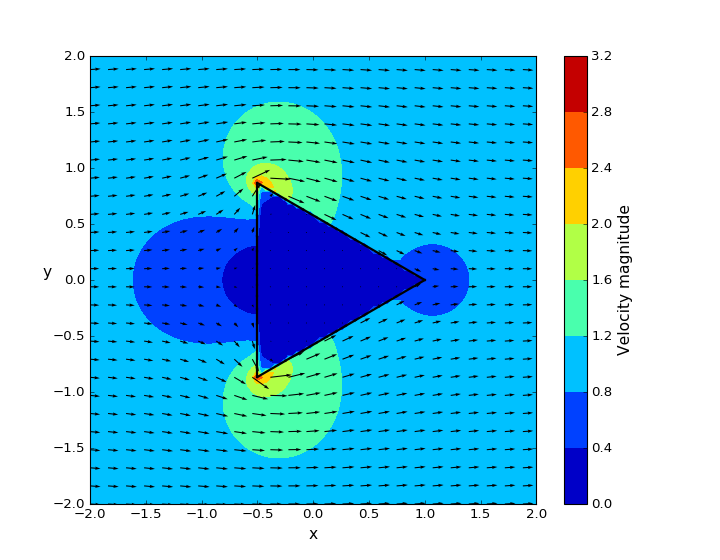

In [24]:
triangle = vp.make_polygon(N=33,sides=3) #1) define geometry
triangle.solve_gamma()                  #2) solve for gamma
triangle.plot_flow()                    #3) compute flow field and plot

Much better! But...

---

##### Quiz

Why is there still flow through the wedge?

1. Modeling error       (ie incorrect conditions)
1. **Numerical error      (ie insufficient resolution)**
1. Implementation error (ie inadequate care)

(Hint: one of these is immediately testable.)

---

##### Numerical Fundamental: Convergence with resolution
##### The numerical solution is improved by using more panels

This example highlights that it is __not the shape__ that is under-resolved. Three panels perfectly describes a triangle shape! 

It is __the distribution of $\gamma(s)$__ that requires a large number of panels to approximate accurately.

---

## Quantitative testing

Let's make this explicitly clear by plotting $\gamma$ versus $s$, the distance around the shape, for a number of resolutions.

The function `PanelArray.get_array` lets you get any attribute on the panels. For example, the half-width of each panel:

In [6]:
print(triangle.get_array('S'))

[ 0.8660254  0.8660254  0.8660254]


And the `distance` function uses this to get the cumulative distance.

```python
def distance(panels):
    S = panels.get_array('S')
    return numpy.cumsum(2*S)-S
```

As always, you can use `help` to see the details of these two functions. For now, let's test convergence with resolution:

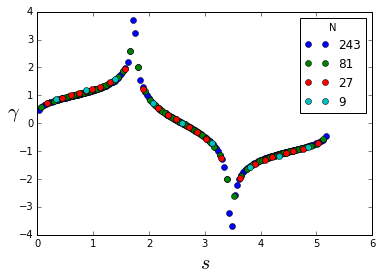

In [7]:
# Loop over resolutions
for N in 3**numpy.arange(5,1,-1):         # N in powers of 3
    triangle = vp.make_polygon(N,sides=3) # define geometry
    s = triangle.distance()               # get distance array

    triangle.solve_gamma()                # solve for gamma
    gamma = triangle.get_array('gamma')   # get gamma array
    pyplot.plot(s,gamma,'o',label=N)      # plot

# finish gamma(s) plot
pyplot.legend(title='N')
pyplot.xlabel(r'$s$', fontsize=20)
pyplot.ylabel(r'$\gamma$', fontsize=20, rotation=0)
pyplot.show()

This plot shows the distribution of $\gamma$ is quite complex. But we can resolve it by increasing the number of panels (at least away from the singular corners). 

## Other shapes

We can now get the flow around **any** shape! Lets try a circle:
```python
def make_circle(N, xcen=0, ycen=0):
    theta = numpy.linspace(0, -2*numpy.pi, N+1)
    x,y = numpy.cos(theta)+xcen, numpy.sin(theta)+ycen
    return panelize(x,y)
```
This code is almost the same as `make_polygon`. The important difference is that $r=1$.

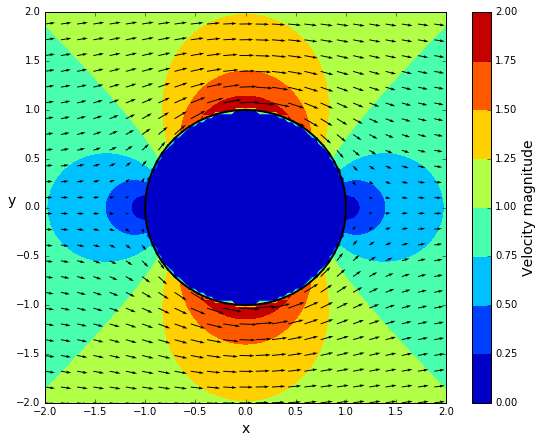

In [8]:
circle = vp.make_circle(64)  # make the shape
circle.solve_gamma()           # solve for gamma
circle.plot_flow()             # compute flow field and plot

Looks about right!

Note that the `make_circle` function takes *optional arguments* to set the $x,y$ location of the center of the circle. Try them out...

##### Quiz

This vortex panel method can be used to solve for the flow around:

1. **an ellipse**
2. **a pair of tandem bodies**
3. **a rudder**

---
##### Your turn #2

 - ** Modify ** the `make_ellipse` function below to generate an ellipse instead of a circle when supplied with an aspect ratio `t_c`=$t/c$.
 - ** Make ** a 2:1 ellipse geometry shifted to be centered at $x=2,y=0$
 - ** Discuss ** whether the maximum speed around the ellipse is greater or less than that around the circle.
 - ** Combine ** the triangle and ellipse geometry together into one set of panels using `vp.concatenate` and solve for the flow.
 - ** Discuss ** if there is a *wake* between the bodies. Why or why not?

---

 
##### Solution #2

<IPython.core.display.Javascript object>


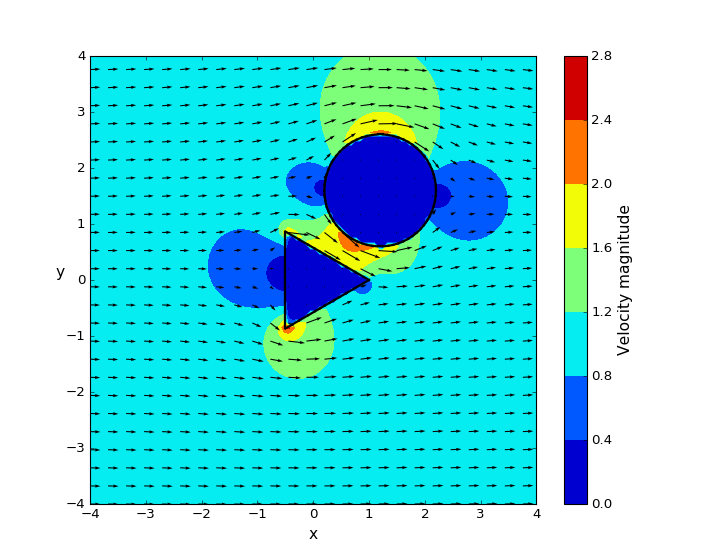

2.2960983032767972

In [58]:
def make_ellipse(N, t_c, xcen=0, ycen=0):
    theta = numpy.linspace(0, -2*numpy.pi, N+1)
    # your code here to define the end-points of the panels for an ellipse
    x = xcen + numpy.cos(theta)  # adjust?
    y = ycen + t_c * numpy.sin(theta)  # adjust?
    return vp.panelize(x, y)

ellipse = make_ellipse(N=66, t_c=1, xcen=1.2, ycen=1.6)   # make the shape
combined = vp.concatenate(triangle, ellipse)
combined.solve_gamma()                         # solve for gamma
combined.plot_flow(size=4)                     # compute flow field and plot
max(ellipse.get_array('gamma'))

In [10]:
# pair = ?   your code using vp.concatenate(a1,a2)